# Case 2

# Transient heat diffusion in food

The heat diffusion through a 2D food sample with dimensions of $1 \times 1$ cm is calculated. The food sample is immersed in a convective environment with a convection coefficient of $20 W/(m^2K)$. The boundary conditions are specified as follows:

Boundary:

- Top: Convection
- Right: Convection
- Bottom: Symmetry
- Left: Symmetry

The thermophysical properties of the food are calculated based on its composition, including the percentages of water (xtw), protein (xp), fat (xfa), carbohydrates (xc), ash (xa), fiber (xfi), and ice (xi). The equations for these properties are obtained from the article: *Choi, Y. O. M. R. (1986). Effects of temperature and composition on the thermal properties of foods. Transport phenomena, 99-101.*


The equations can be found in the file foosProperties.py

In [1]:
import numpy as np
import pyconduct as pyc
from numba import jit
import matplotlib.pyplot as plt
import foodProperties as fp

In [2]:
xtw = 78.96 / 100.
xp = 2.07 / 100.
xfa = 0.10 / 100.
xc = 17.98 / 100.
xa = 0.89 / 100.
xfi = 0.

t0 = 15.
tf = 250.

# Average temperature
tm = (t0 + tf) * 0.5

# Density
rho = fp.rhof(xtw = xtw, xp = xp, xfa = xfa, xc = xc, xa = xa, xfi = xfi, xi = 0., t = tm)
# Specific heat
cp = fp.cpf(xtw = xtw, xp = xp, xfa = xfa, xc = xc, xa = xa, xfi = xfi, xi = 0., t = tm)
# Thermal conductivity
cond = fp.condf(xtw = xtw, xp = xp, xfa = xfa, xc = xc, xa = xa, xfi = xfi, xi = 0., t = tm)

print(rho)
print(cp)
print(cond)

1016.0080774400686
3690.9019736858745
0.6345327771201139


The Biot number is calculated as follows:

$$ Bi = \frac{h L_c}{k} \quad \quad L_c = \frac{Vol}{A_s}$$

In [4]:
h = 20.
H = 1. / 100.
W = H
D = H * 10.
V = H * D * W
A = 2. * W * H + 4. * H * D
Lc = V / A
Bi = h * Lc / cond
print(Bi)

0.07504584370750886


The Biot number is found to be less than 0.1, indicating negligible internal resistance. The following model can be applied to predict the temperature:

$$ \frac{T - T_f}{T_i - T_f} = e^{-Bi Fo} \quad \quad Fo = \frac{\alpha t}{L_c^2}\quad \quad \alpha = \frac{k}{\rho C_p}$$


The geometry is created, default values are set, and the case is initialized with a uniform temperature of $15^oC$. The simulation time "timeEnd" is set to 3600 seconds, and the time step dt is 1 second.

In [8]:
c = pyc.PyConduct()

###############################
# USER: Geometry
###############################
H = 1. / 100.
W = H
c.lx = W * 0.5
c.ly = H * 0.5
c.ncvx = 25
c.ncvy = 25
###############################

c.set_default()

###############################
# USER: Initialization
###############################
t0 = 15.
c.phi[:] = t0
c.timeEnd = 3600.
c.dt = 1.
###############################

c.meshing()

The value of $\Gamma$ is calculated as 0.6345 based on previous calculations. The value of $\lambda$ is equivalent to the product of specific heat and density. The convective ambient temperature tinf is $250^oC$, and the convection coefficient h is $20 W/(m^2K)$.

The Robin boundary conditions are established as follows:

$$ S_C = \left(\frac{h_B \frac{k_B}{\delta x_B}}{h_B + \frac{k_B}{\delta x_B}}\right) T_{\infty} A_B \quad \quad S_P = -\left(\frac{h_B \frac{k_B}{\delta x_B}}{h_B +\frac{k_B}{\delta x_B}}\right) A_B $$

The source terms are zero in this case, and the transient term is discretized using forward Euler.

In [9]:
@jit
def gammaUSER(t, xc, yc):
    gam = 0.6345327771201139
    return gam

@jit
def lambUSER(t, xc, yc):
    cp = 3690.9019736858745
    rho = 1016.0080774400686
    rhocp = rho * cp
    return rhocp

@jit
def sourcesBound(b, c, f, i, ndist, cvol, af, gamma, lamb, xf, yf, timer):
    tinf = 250.
    hb = 20.
    gam = gamma[c]
    dx = ndist[i]
    vol = cvol[c]
    area = af[f]
    
    if(b == 1):
        scb = 0.
        spb = 0.
    elif(b == 2):
        scb = ((hb * gam / dx) / (hb + gam / dx)) * tinf * area
        spb = -((hb * gam / dx) / (hb + gam / dx)) * area
    elif(b == 3):
        scb = ((hb * gam / dx) / (hb + gam / dx)) * tinf * area
        spb = -((hb * gam / dx) / (hb + gam / dx)) * area
    elif(b == 4):
        scb = 0.
        spb = 0.
    else:
        scb = 0.
        spb = 0.
    return scb, spb

@jit
def sourcesVol(c, vol, phi, xc, yc, timer):
    scv = 0.
    spv = 0.
    return scv, spv

@jit              
def unsteadySources(phi, phi1, phi2, lamb, dt, cvol, c, titer):
    vol = cvol[c]
    #Euler
    ap0 = lamb[c] / dt * vol
    apts = -ap0 
    acts = ap0 * phi1[c]
    return apts, acts

Three monitors are created to track the temperature at three positions: the nearest to the origin, the farthest, and an intermediate position.

- reportBlackW: Displays a report on the screen every 600 time steps
- reportContour: Displays a contour plot of $\phi$ on the screen every 1000 time steps
- writeContour: Records data in the monitor file every 600 time steps
- Validation

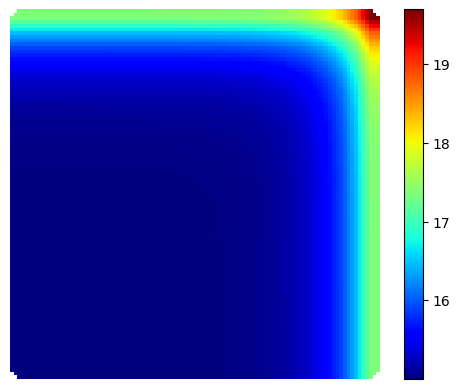

time = 600.0  iter_t = 600  nl_iter = 1  errNl = 0.0


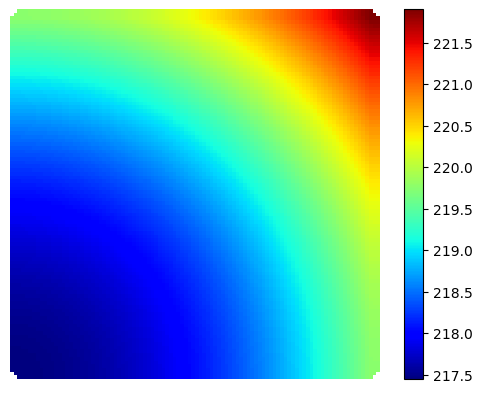

time = 1200.0  iter_t = 1200  nl_iter = 1  errNl = 0.0
time = 1800.0  iter_t = 1800  nl_iter = 1  errNl = 0.0


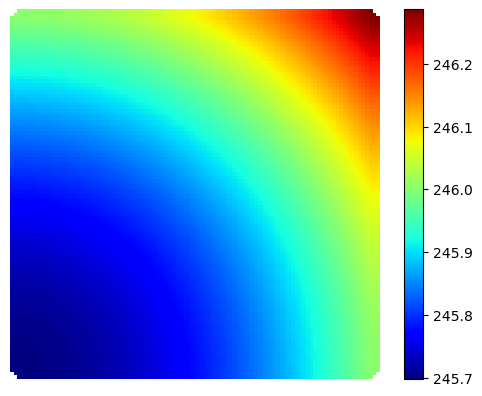

time = 2400.0  iter_t = 2400  nl_iter = 1  errNl = 0.0
time = 3000.0  iter_t = 3000  nl_iter = 1  errNl = 0.0


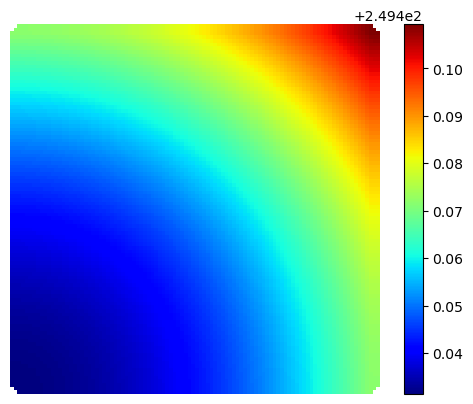

time = 3600.0  iter_t = 3600  nl_iter = 0  errNl = 1.0638383895657437e-07
calculation complete


In [10]:
c.gammaFunction = gammaUSER
c.lambFunction = lambUSER
c.unsteadySourcesFunction = unsteadySources
c.sourcesVolFunction = sourcesVol
c.sourcesBoundFunction = sourcesBound

c.monitors = np.array([[0., 0.],[c.lx * 0.5, c.ly * 0.5], [c.lx * 0.98, c.ly * 0.98]])
c.monNames = np.array(["$(0,0)$", "$(0.5 l_x, 0.5 l_y)$", "$(l_x, l_y)$"])

c.sol = 1
c.reportBlackW = 600
c.reportContour = 1000
c.writeContour = 600
c.run_simulation()

**Validation**

A function is created to calculate the solution for the negligible internal resistance model:

In [15]:
def Trid(Lc, t0, tf, k, rho, cp, h, t):
    Bi = h * Lc / k
    alpha = k / (rho * cp)
    Fo = alpha * t / (Lc**2)
    T = (t0 - tf) * np.exp(-Bi * Fo) + tf
    return T

t = np.linspace(0., 3600., 20)
data = np.loadtxt(fname = "monitors.csv", skiprows=1, delimiter=",")

 The analytical solution is compared with the numerical results obtained from the monitors:

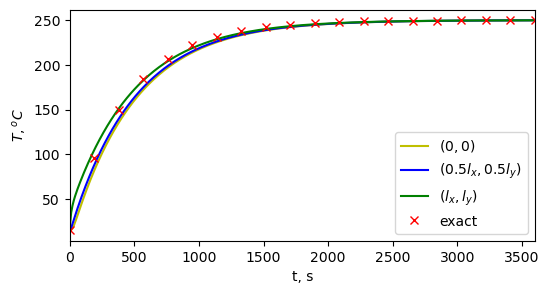

In [16]:
plt.figure(figsize = (6, 3))
# Numerical Solution
plt.plot(data[:,0], data[:,1], "y-", label = c.monNames[0])
plt.plot(data[:,0], data[:,2], "b-", label = c.monNames[1])
plt.plot(data[:,0], data[:,3], "g-", label = c.monNames[2])
# Exact Solution
plt.plot(t, Trid(Lc, t0, tf, cond, rho, cp, h, t), "rx", label = "exact")
plt.xlim(0., 3600.)
plt.legend(loc = "best")
plt.xlabel("t, s")
plt.ylabel("$T, ^oC$")
plt.show()